# Deep Learning Begginers Kernel
In this kernel, I'll try basic RNN+CNN approach.



For educational purposes I didnt look much into other kernels for this competitions.
I highly relied on ["Deep Learning with Python"](https://books.google.ru/books?id=dadfDwAAQBAJ&printsec=frontcover&dq=francois+chollet+deep+learning&hl=ru&sa=X&ved=0ahUKEwjOnNeTl4riAhWFw6YKHXpXD_kQ6AEIKTAA#v=onepage&q=francois%20chollet%20deep%20learning&f=false) by François Chollet though, you should definetely check it out.

I'm a beginner at Deep Learning and Machine Learning in general, so any feedback is highly appreciated: if you have any questions, remarks or suggestions, please let me know!

## Downloading and exploring the data

In [1]:
# I'll put  all the nesessary libraries here
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from scipy import signal
import os
import seaborn as sns
from tqdm import tqdm
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import StratifiedShuffleSplit

from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Activation, Conv1D, Flatten, Dropout, TimeDistributed, Bidirectional, MaxPooling1D, SpatialDropout1D, GlobalAveragePooling1D
from tensorflow.python.keras.layers import GlobalMaxPooling1D, BatchNormalization
from tensorflow.keras.layers import GRU, LSTM, CuDNNGRU, CuDNNLSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import Input, Model

In [2]:
# Disabling the warnings
import warnings
warnings.filterwarnings("ignore")
matplotlib.rcParams['figure.figsize'] = (15.0, 5.0)

In [3]:
# Downloading the training set
df_train = pd.read_csv('../input/X_train.csv')
target_train = pd.read_csv('../input/y_train.csv')

# Lets see whats inside
df_train.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410


Lets look at the first measurement:

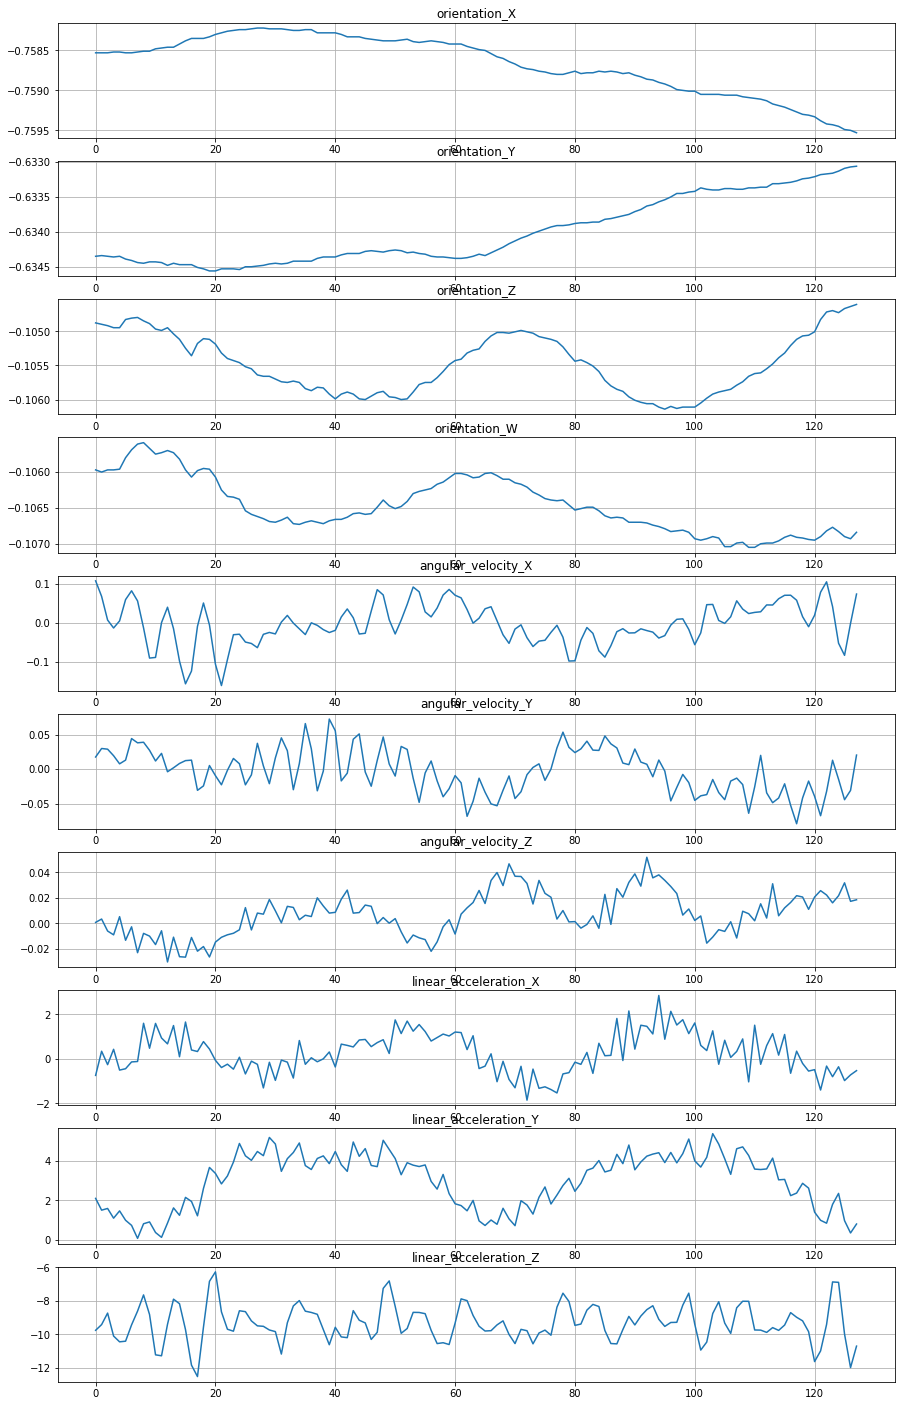

In [4]:
plt.figure(figsize=(15,25))
for i, column in enumerate(df_train.columns[3:]):
    plt.subplot(10,1,i+1)
    plt.plot(df_train[column][:128])
    plt.title(column)
    plt.grid()

Since we have different physical quantities we shall have to scale the data. We dont have very large outliers so I guess scaling each physical quantity to unit variance will do the job.
We shall also have to remove the trend from the data because, for example, whether the robot is turning left or right or the overall increase of acceleration is irrlevant.

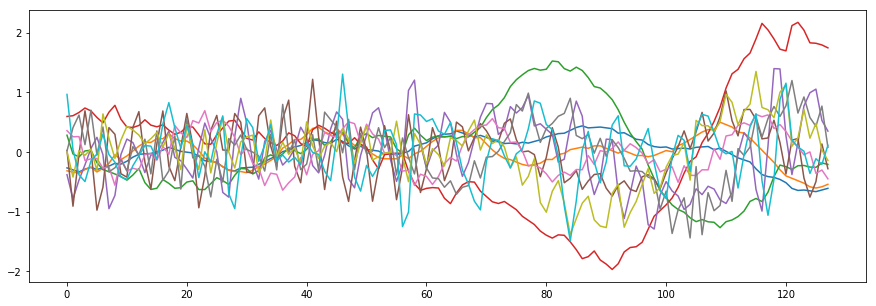

In [5]:
# I am declaring a function so we could use it for the test set later as well
def create_X(df, nrows):
    # The data will be organized into 3D numpy array with shape (series id, measurement number, channel)
    X = np.zeros((nrows,128,10))
    X[:,:,0] = df['orientation_X'].values.reshape((-1,128))
    X[:,:,1] = df['orientation_Y'].values.reshape((-1,128))
    X[:,:,2] = df['orientation_Z'].values.reshape((-1,128))
    X[:,:,3] = df['orientation_W'].values.reshape((-1,128))

    X[:,:,4] = df['angular_velocity_X'].values.reshape((-1,128))
    X[:,:,5] = df['angular_velocity_Y'].values.reshape((-1,128))
    X[:,:,6] = df['angular_velocity_Z'].values.reshape((-1,128))

    X[:,:,7] = df['linear_acceleration_X'].values.reshape((-1,128))
    X[:,:,8] = df['linear_acceleration_Y'].values.reshape((-1,128))
    X[:,:,9] = df['linear_acceleration_Z'].values.reshape((-1,128))
    
    # Detrending each signal
    for i in range(10):
        X[:,:,i] = signal.detrend(X[:,:,i])
        
    # Scaling groups of channels corresponding to different physical quantities to standard deviation
    X[:,:,[0,1,2,3]] = X[:,:,[0,1,2,3]]/X[:,:,[0,1,2,3]].std()
    X[:,:,[4,5,6]] = X[:,:,[4,5,6]]/X[:,:,[4,5,6]].std()
    X[:,:,[7,8,9]] = X[:,:,[7,8,9]]/X[:,:,[7,8,9]].std()

    return X

X = create_X(df_train, 3810)
_ = plt.plot(X[10])

Now lets look at the tagets.


In [6]:
target_train.head()

,series_id,group_id,surface
0,0,13,fine_concrete
1,1,31,concrete
2,2,20,concrete
3,3,31,concrete
4,4,22,soft_tiles


In [7]:
# I'm using the LabelEncoder to turn text labels into vector of integers...
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(target_train.surface.values.reshape(-1,1))
labels = le.transform(target_train.surface.values.reshape(-1,1))
# ... and than to binary class matrix
y = to_categorical(labels)

Lets look at the distribution of labels:

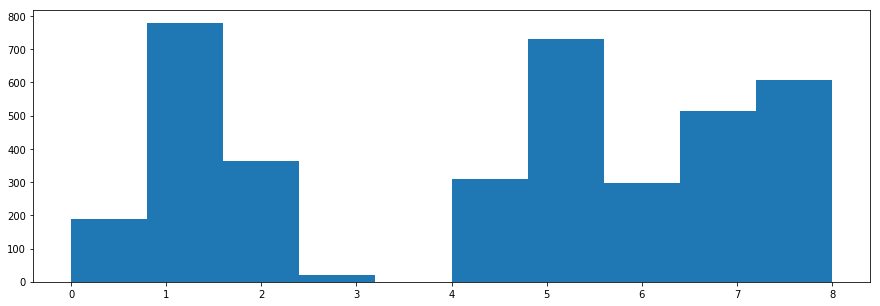

In [23]:
_ = plt.hist(labels)

As we can see from the histogram, we have unbalanced classes, so we need stratified cross-validator to preserve the percentage of samples for each class in both train and validation sets. I think, StratifiedShuffleSplit will do the job.

In [9]:
sss = StratifiedShuffleSplit(n_splits=1,test_size=0.2)
train_index, test_index = next(sss.split(X, y))
X_train, X_val = X[train_index], X[test_index]
y_train, y_val = y[train_index], y[test_index]

In [10]:
# I'm creating a generator so we can endlessly feed batches of random samples for our model to train
def data_generator(batch_size):
    while True:
        batch_index = np.random.choice(train_index, batch_size)
        X_out = X[batch_index]            
        yield X_out, y[batch_index]

train_gen = data_generator(64)
next(train_gen)[1].shape

(64, 9)

Now we can build our first model.

In [11]:
# I took the function below from this kernel, very helpful:
# https://www.kaggle.com/mayer79/rnn-starter-for-huge-time-series
def history_plot(history, what):
    x = history.history[what]
    val_x = history.history['val_' + what]
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = np.asarray(history.epoch) + 1
    
    plt.subplot(1,2,1)
    plt.plot(epochs, x, 'b', label = "Training " + what)
    plt.plot(epochs, val_x, 'r', label = "Validation " + what)
    plt.grid()
    plt.title("Training and validation " + what)
    plt.xlabel("Epochs")
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.plot(epochs, loss, 'b', label = "Training loss")
    plt.plot(epochs, val_loss, 'r', label = "Validation loss")
    plt.grid()
    plt.title("Training and validation " + what)
    plt.xlabel("Epochs")
    plt.legend()
    plt.show()
    return None

# 1. Basic RNN model

As we are dealing with time sequences and RNN are known to deal well with sequential data, RNN seems to be the right choice to start.
As a baseline, let's start with the most straightforward solution, directly connecting the RNN layer. *(I chose GRU over LSTM for no particular reason as they demonstrated no significant difference in this baseline solution.)*

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnngru (CuDNNGRU)         (None, 32)                4224      
_________________________________________________________________
dense (Dense)                (None, 9)                 297       
Total params: 4,521
Trainable params: 4,521
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.cast instead.
762/762 [==============================] - 0s 74us/sample - loss: 1.4591 - acc: 0.4816


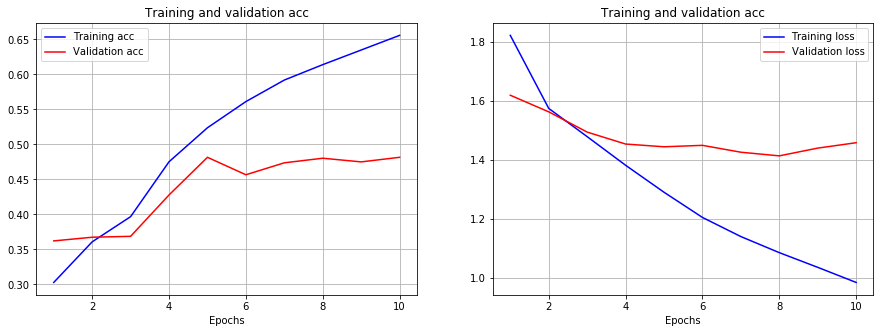

In [12]:
model = Sequential()
# Again I chose 32 units as a starting point just because starting examples in "Deep Learning with Python" by François Chollet. 
# I dont really know any hard theory behind this decision.
model.add(CuDNNGRU(32, input_shape=(128,10))) 
model.add(Dense(9, activation='softmax'))
model.summary()
model.compile(optimizer=RMSprop(), loss="categorical_crossentropy", metrics=['accuracy'])

history = model.fit_generator(train_gen,epochs=10, steps_per_epoch=500, validation_data=(X_val, y_val),verbose=False)
history_plot(history, what='acc')

# 2. Adding CNN layer 

Our model isn't doing great so far. It also shows signs of overfitting. Lets try using a convolution layer for preprocessing data before feeding it to the recurrent layer.

In [20]:
model = Sequential()
# And again, the number of filter I used and the kernel size is a bit of guesswork
model.add(Conv1D(filters=150,kernel_size=10,activation='relu', input_shape=(128,10)))
# I'm using MaxPolling to reduce dimentionality of convolution layer before feeding it to GRU
model.add(MaxPooling1D(2))
# I have also added dropout to prevent overfitting
model.add(Dropout(0.5))
model.add(CuDNNGRU(32))
model.add(Dropout(0.5))
model.add(Dense(9, activation='softmax'))
model.summary()

model.compile(optimizer=Adam(), loss="categorical_crossentropy", metrics=['accuracy'])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=3, min_lr=0.001)
history = model.fit_generator(train_gen,epochs=50, steps_per_epoch=1000, validation_data=(X_val, y_val),
                             callbacks=[reduce_lr])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 119, 150)          15150     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 59, 150)           0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 59, 150)           0         
_________________________________________________________________
cu_dnngru_3 (CuDNNGRU)       (None, 32)                17664     
_________________________________________________________________
dropout_5 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 9)                 297       
Total params: 33,111
Trainable params: 33,111
Non-trainable params: 0
_________________________________________________________________


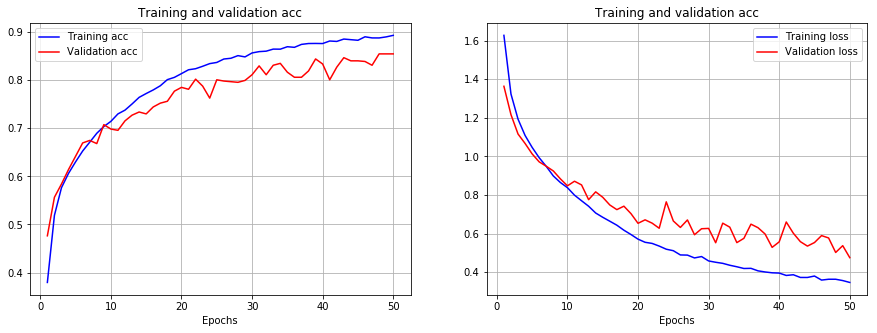

In [19]:
history_plot(history, what='acc')

# 3. Data augumentation

Another thing we can do to prevent overfitting is to enlarge our training set by manipulating trainig samples.

Lets adopt the hypothesis that if we reverse time sequence, and inverse signal, the patterns that define the type of surface will stay the same. So I'll mody the generator so that it will randomly reverse/inverse the batch before feeding it to the model.

In [14]:
def aug_generator(batch_size):
    while True:
        batch_index = np.random.choice(train_index, batch_size)
        X_out = X[batch_index]
        if (np.random.randint(0,2)):
            # randomly reversing all the samples in the batch
            X_out = np.flip(X[batch_index],axis=1)
        if (np.random.randint(0,2)):
            # randomly inversing all the samples in the batch
            X_out = - X[batch_index]
            
        yield X_out, y[batch_index]

train_gen = aug_generator(64)

In [22]:
model = Sequential()
model.add(Conv1D(filters=150,kernel_size=10,activation='relu', input_shape=(128,10)))
model.add(MaxPooling1D(2))
model.add(Dropout(0.5))
model.add(CuDNNGRU(32))
model.add(Dropout(0.5))
model.add(Dense(9, activation='softmax'))
model.summary()

model.compile(optimizer=Adam(), loss="categorical_crossentropy", metrics=['accuracy'])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=3, min_lr=0.001)
history = model.fit_generator(train_gen,epochs=50, steps_per_epoch=1000, validation_data=(X_val, y_val),
                             callbacks=[reduce_lr])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 119, 150)          15150     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 59, 150)           0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 59, 150)           0         
_________________________________________________________________
cu_dnngru_4 (CuDNNGRU)       (None, 32)                17664     
_________________________________________________________________
dropout_7 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 9)                 297       
Total params: 33,111
Trainable params: 33,111
Non-trainable params: 0
_________________________________________________________________
Epoch 

KeyboardInterrupt: 

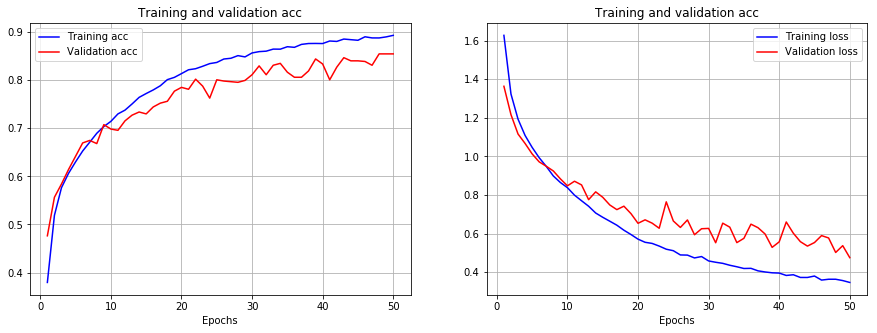

In [16]:
history_plot(history, what='acc')

We can see that despite our model starts overfitting significantly later and the perfonmance is much better.

## Predicting on test set and submitting

In [17]:
df_test = pd.read_csv('../input/X_test.csv')
submission = pd.read_csv('../input/sample_submission.csv')
X_test = create_X(df_test, 3816)

In [24]:
y_test = np.argmax(model.predict(X_test, verbose=1),axis=1)
preds = le.inverse_transform(y_test.reshape(-1,1))
submission['surface'] = preds
submission.to_csv('submission.csv',index=False)
print(preds)

['hard_tiles_large_space' 'concrete' 'tiled' ... 'carpet' 'tiled' 'wood']


# P.S.

I tried using CNN with signal spectrums as input, but I could not get a result better then 0.64 on validation set.